# DENUE information

@roman

1 julio, 2024

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import h3
from tqdm import tqdm
from dotenv import load_dotenv

from INEGIpy import DENUE, MarcoGeoestadistico

In [31]:
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)

# Load environment variables
load_dotenv()

# inegi class
denue_api = DENUE(token=os.getenv('API_INEGI'))
inegi_api = MarcoGeoestadistico()


---
# Data

## Cities

In [3]:
# read parquet
gdf_cities = gpd.read_parquet("../../data/misc/polygons_cities_analysis.parquet")

# change crs to 6372
gdf_cities = gdf_cities.to_crs("EPSG:6372")

gdf_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city_cluster  158 non-null    int64   
 1   geometry      158 non-null    geometry
 2   id_entidad_f  158 non-null    object  
 3   id_municipio  158 non-null    object  
dtypes: geometry(1), int64(1), object(2)
memory usage: 5.1+ KB


In [4]:
# Ensure we use lat/lon coordinates
def latlon_to_h3(latitudes, longitudes, resolution):
    # Ensure inputs are numpy arrays
    latitudes = np.asarray(latitudes)
    longitudes = np.asarray(longitudes)
    
    # Check that latitudes and longitudes are the same shape
    if latitudes.shape != longitudes.shape:
        raise ValueError("Latitudes and longitudes must be the same shape")
    
    # Vectorize the h3 function
    vectorized_h3 = np.vectorize(h3.geo_to_h3)
    
    # Apply the function to the latitude and longitude arrays
    hex_ids = vectorized_h3(latitudes, longitudes, resolution)
    
    return hex_ids

def to_latlon(gdf):
    if gdf.crs is not None and gdf.crs.to_string() != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')
    return gdf

# Get all H3 hexagons covering a shapely geometry
def h3_polyfill(geometry, resolution):
    hexagons = set()
    if geometry.geom_type == 'Polygon':
        hexagons.update(h3.polyfill(geometry.__geo_interface__, resolution, geo_json_conformant=True))
    elif geometry.geom_type == 'MultiPolygon':
        for poly in geometry:
            hexagons.update(h3.polyfill(poly.__geo_interface__, resolution, geo_json_conformant=True))
    return hexagons

# Create GeoDataFrame of H3 hexagons from a set of H3 indices
def hexagons_to_geodf(hexagons, crs):
    # each hexagon to polygon
    polygons = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hexagons]
    # create geodataframe
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
    return gdf

# Vectorized function to compute hexagons
def create_hex_grid_vectorized(gdf, resolution):
    # copy
    gdf = gdf.copy()

    # buffer by 1km the geometries
    gdf = gdf.to_crs('EPSG:6372')
    gdf['geometry'] = gdf['geometry'].buffer(1_000)

    # Convert GeoDataFrame to lat/lon if not already
    gdf = to_latlon(gdf)

    # Get H3 hexagons for all geometries
    hex_sets = np.array([h3_polyfill(geom, resolution) for geom in gdf['geometry']])
    
    # Flatten the hexagon sets
    all_hexagons = set().union(*hex_sets)

    # Convert H3 indices to GeoDataFrame
    hex_gdf = hexagons_to_geodf(all_hexagons, gdf.crs)

    # Get lon & lat
    hex_gdf['longitude'] = hex_gdf.centroid.x
    hex_gdf['latitude'] = hex_gdf.centroid.y

    # Get hex-id
    hex_gdf['hex_id'] = latlon_to_h3(
        hex_gdf['latitude'].values,
        hex_gdf['longitude'].values,
        resolution
    )

    return hex_gdf

# Define the H3 resolution
resolution = 7

# Create the hexagon grid
gdf_hex = create_hex_grid_vectorized(gdf_cities, resolution)
gdf_hex


/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_49544/182453498.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hex_gdf['longitude'] = hex_gdf.centroid.x
/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_49544/182453498.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hex_gdf['latitude'] = hex_gdf.centroid.y


,geometry,longitude,latitude,hex_id
0,"POLYGON ((-103.34797 25.59949, -103.33909 25.6...",-103.354369,25.612107,874812712ffffff
1,"POLYGON ((-103.23530 20.47770, -103.22677 20.4...",-103.241439,20.490227,8749aa289ffffff
2,"POLYGON ((-99.18162 18.93654, -99.17297 18.947...",-99.187206,18.949027,8749b32c6ffffff
3,"POLYGON ((-100.52594 19.66901, -100.51730 19.6...",-100.531722,19.681529,87498052affffff
4,"POLYGON ((-100.97105 25.42420, -100.96203 25.4...",-100.977155,25.436870,8748a0794ffffff
...,...,...,...,...
4477,"POLYGON ((-103.37156 20.66921, -103.36303 20.6...",-103.377725,20.681739,87498c968ffffff
4478,"POLYGON ((-100.42259 20.70023, -100.41388 20.7...",-100.428408,20.712800,874983c8dffffff
4479,"POLYGON ((-100.40515 20.66253, -100.39644 20.6...",-100.410965,20.675095,874983caaffffff
4480,"POLYGON ((-98.14777 19.38446, -98.13904 19.395...",-98.153241,19.396970,8749942ecffffff


In [5]:
# look for hexagons in the cities
gdf_hex.explore(tiles='cartodb positron', tooltip='hex_id')

^^^
note:
- hex with resolution 7 has a side length of 1.4km, which translates to an apothem of 1.2km and an area of 5.16km^2

## Mexico

In [32]:
# get mexico shapes
gdf_mexico = inegi_api.Entidades()
gdf_mexico.shape

(32, 9)

<Axes: >

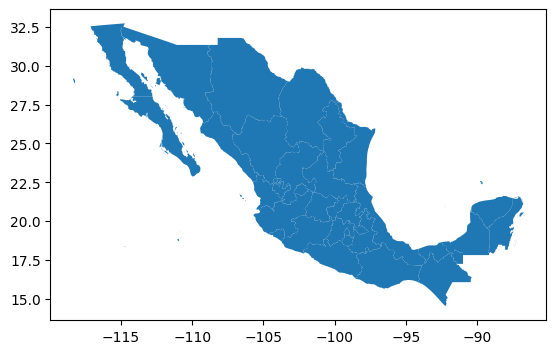

In [33]:
# plot
gdf_mexico.plot()

---
# Scouting Data

## How to fetch

### Buscar Method

In [6]:
# subset
gdf_hex_sample = gdf_hex.query("hex_id == '874995baeffffff'")
RADIUS = 5_000  # 1km

In [7]:
gdf_hex_sample

,geometry,longitude,latitude,hex_id
349,"POLYGON ((-99.18283 19.42507, -99.17415 19.436...",-99.188437,19.437583,874995baeffffff


In [8]:
# search denue
gdf_supermarkets = denue_api.Buscar(
    'walmart, oxxo',
    latitud=gdf_hex_sample['latitude'].values[0],
    longitud=gdf_hex_sample['longitude'].values[0],
    distancia=RADIUS
)
# see
gdf_supermarkets

https://www.inegi.org.mx/app/api/denue/v1/consulta/Buscar/walmart, oxxo/19.4375834332844,-99.18843720864304/5000/b4f50704-61f4-4343-8aeb-79c7e12761c4


,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,Colonia,CP,Ubicacion,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,CentroComercial,TipoCentroComercial,NumLocal,geometry
0,09016462112000932000008202S5,6315366,OXXO SUC 50HEG HEGEL MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,AVENIDA,EJÃ¿RCITO NACIONAL MEXICANO,430,,POLANCO REFORMA,11550,"MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO",,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.188361,19.437619,,,,POINT (-99.18836 19.43762)
1,09016462112000612000008202S3,6325066,OXXO SUC 50EJC EJERCITO MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,AVENIDA,EJÃ¿RCITO NACIONAL MEXICANO,505,,GRANADA,11520,"MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO",,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.190459,19.437986,,,,POINT (-99.19046 19.43799)
2,09016462112001722000008202S9,6307292,OXXO SUC 50WOB MARIANO MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,AVENIDA,GENERAL MARIANO ESCOBEDO,373,,ANAHUAC,11320,"MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO",,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.188801,19.433504,,,,POINT (-99.18880 19.43350)
3,09016462112003362000008202S2,9396516,OXXO SUC 50T27 LAGO ALBERTO II,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,LAGO ALBERTO,,,ANAHUAC,11320,"MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO",,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.184811,19.439916,,,,POINT (-99.18481 19.43992)
4,09016462112002372000008202S2,6706023,OXXO SUC 50LIS PLAZA ARQUIMIDES MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,ARQUÃMEDES,130,,POLANCO CHAPULTEPEC,11560,"MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO",,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.190942,19.433718,PLAZA ARQUIMIDES,CENTRO Y PLAZA COMERCIAL,SN,POINT (-99.19094 19.43372)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,09015462112003462000008202S2,6317650,OXXO SUC 50XYJ DOCTORES I MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,DOCTOR JOSÉ TERRÉS,29,,DOCTORES,06720,"CUAUHTÉMOC, Cuauhtémoc, CIUDAD DE MÉXICO",,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.146579,19.416988,,,,POINT (-99.14658 19.41699)
328,09014462112004502000008202S7,9392847,OXXO SUC 50XU9 ARIZONA MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,ARIZONA,,,NAPOLES,03810,"BENITO JUÁREZ, Benito Juárez, CIUDAD DE MÉXICO",,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.175436,19.394569,,,,POINT (-99.17544 19.39457)
329,09015462112007112000008202S9,9436453,OXXO SUC 50J10 DR PASCUA MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,DOCTOR VALENZUELA,,,DOCTORES,06720,"CUAUHTÉMOC, Cuauhtémoc, CIUDAD DE MÉXICO",,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.143956,19.422450,,,,POINT (-99.14396 19.42245)
330,09015462112004661001008202S8,6723810,OXXO SUC 50QUR RIVA PALACIO II MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,EJE VIAL,1 PONIENTE (GUERRERO),395,,NONOALCO TLATELOLCO,06900,"CUAUHTÉMOC, Cuauhtémoc, CIUDAD DE MÉXICO",,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.144890,19.455045,,,,POINT (-99.14489 19.45504)


notes:
- if it doesnt find any supermarket then it breaks with an ConnectionError, `BadStatusLine('HTTP/1.1 000 \r\n')`

todo:
- define names of supermarkets, hospitals and schools to search
- minimum estrata to count 
- type of `tipo`
- maybe define razon social to always count the same type

### BuscarAreaActEstr Method

In [24]:
# search all supermarkets
gdf_supermarkets_cdmx = denue_api.BuscarAreaAct(
    nombre='supermercado',
    clave_area='00',
    # clave_actividad='462111',
    registro_inicial=0,
    registro_final=100_000,
    estrato='0'
)
# see
gdf_supermarkets_cdmx

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,Colonia,CP,Ubicacion,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,tipo_corredor_industrial,nom_corredor_industrial,numero_local,AGEB,Manzana,CLASE_ACTIVIDAD_ID,EDIFICIO_PISO,SECTOR_ACTIVIDAD_ID,SUBSECTOR_ACTIVIDAD_ID,RAMA_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,EDIFICIO,Tipo_Asentamiento,Fecha_Alta,AreaGeo,geometry
0,11017462111000147000003517S6,6330332,010 LA COMER IRAPUATO,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,CALLE,CALLE DEL BOSQUE,1,,LAS REYNAS,36660,"IRAPUATO, Irapuato, GUANAJUATO",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-101.357738,20.690109,,,,0097,049,462111,,46,462,4621,46211,,FRACCIONAMIENTO,2010-07,110170001,POINT (-101.35774 20.69011)
1,15104462111000326000003517S9,6354328,012 LACOMER EL DORADO,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,251 y más personas,CALLE,ATENAS,6,,VALLE DORADO,54020,"TLALNEPANTLA, Tlalnepantla de Baz, MÉXICO ...",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-99.213886,19.546376,,,,0232,019,462111,,46,462,4621,46211,,FRACCIONAMIENTO,2010-07,151040001,POINT (-99.21389 19.54638)
2,15037462111000066000003517S6,6353986,014 LA COMER LOMAS ANAHUAC,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,251 y más personas,AVENIDA,DE LAS PALMAS,1,2,SAN FERNANDO HUIXQUILUCAN,52784,"NAUCALPAN DE JUÁREZ, Huixquilucan, MÉXICO ...",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-99.274747,19.399433,,,,0115,015,462111,,46,462,4621,46211,,COLONIA,2010-07,150370071,POINT (-99.27475 19.39943)
3,09012462111000086000003517S9,6314534,017 LA COMER TLALPAN,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,CALLE,AYUNTAMIENTO,1,,LA FAMA,14110,"TLALPAN, Tlalpan, CIUDAD DE MÉXICO",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-99.179404,19.289452,,,,0680,003,462111,,46,462,4621,46211,,COLONIA,2010-07,090120001,POINT (-99.17940 19.28945)
4,16102462111000076000003517S4,6358942,034 LA COMER URUAPAN,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,CALLE,PASEO GENERAL LÁZARO CÁRDENAS,1800,,LOS ANGELES,60160,"URUAPAN, Uruapan, MICHOACÁN DE OCAMPO",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-102.055348,19.401290,,,,0374,004,462111,,46,462,4621,46211,,COLONIA,2010-07,161020001,POINT (-102.05535 19.40129)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7423,12075461110007071000000000U1,8420963,YULI SUPER,,Comercio al por menor en supermercados,0 a 5 personas,AVENIDA,20 DE NOVIEMBRE,,,SANTA ANITA,40185,"ZUMPANGO DEL RÍO, Eduardo Neri, GUERRERO",7473998797,,,Fijo,-99.524087,17.648001,,,,049A,020,462111,,46,462,4621,46211,,BARRIO,2019-11,120750001,POINT (-99.52409 17.64800)
7424,09004462111000171000000000U8,9439732,ZIEDIMEX,ZIEDIMEX SA DE CV,Comercio al por menor en supermercados,0 a 5 personas,CALLE,SAN JOSÉ DE LOS CEDROS,10,,SAN JOSE DE LOS CEDROS,05200,"CUAJIMALPA DE MORELOS, Cuajimalpa de Morelos, ...",5539843584,EDUFDLOEE@YAHOO.COM.MX,,Fijo,-99.287438,19.365435,PASAJE Y ANDADOR COMERCIAL,AVENIDA SAN JOSE DE LOS CEDROS,79,0354,004,462111,4,46,462,4621,46211,10,COLONIA,2023-11,090040001,POINT (-99.28744 19.36544)
7425,16066462111000093000058299S4,9405091,ZUPER CODALLOS LA ERA,VICA ABARROTERA SA DE CV,Comercio al por menor en supermercados,11 a 30 personas,CALLE,TRIGO,,,ERENDIRA,61605,"PÁTZCUARO, Pátzcuaro, MICHOACÁN DE OCAMPO",,AUXILIARCONTABLE@SUPERCODALLOS.COM,,Fijo,-101.600797,19.498537,,,,0179,024,462111,,46,462,4621,46211,,COLONIA,2023-11,160660001,POINT (-101.60080 19.49854)
7426,16066462111000082000058299S7,9453171,ZUPER CODALLOS LA ERA,VICA ABARROTERA SA DE CV,Comercio al por menor en supermercados,6 a 10 personas,CALLE,EL PEAJE,193,,LA ILUSION,61605,"PÁTZCUARO, Pátzcuaro, MICHOACÁN DE OCAMPO",,AUXILIAR

In [22]:
# search all supermarkets
gdf_hospitals_all_mex = denue_api.BuscarAreaAct(
    nombre='hospital',
    clave_area='00',
    # clave_actividad='462111',
    registro_inicial=0,
    registro_final=100_000,
    estrato='0'
)
# see
gdf_hospitals_all_mex

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,Colonia,CP,Ubicacion,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,tipo_corredor_industrial,nom_corredor_industrial,numero_local,AGEB,Manzana,CLASE_ACTIVIDAD_ID,EDIFICIO_PISO,SECTOR_ACTIVIDAD_ID,SUBSECTOR_ACTIVIDAD_ID,RAMA_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,EDIFICIO,Tipo_Asentamiento,Fecha_Alta,AreaGeo,geometry
0,22014621113002531010000000U7,3563539,1T410 CONSULTORIO UROLOGIA,,Hospitales del sector privado de otras especia...,0 a 5 personas,PRIVADA,IGNACIO ZARAGOZA,16,410,EL CARRIZAL,76030,"SANTIAGO DE QUERÉTARO, Querétaro, QUERÉTARO ...",4422955309,,,Fijo,-100.399697,20.584241,"HOSPITAL, CENTRO MEDICO O CLINICA",TEC 100 H+,410,1316,009,622311,20,62,622,6223,62231,TORRE 1,COLONIA,2010-07,220140001,POINT (-100.39970 20.58424)
1,14039622311000583001000000U6,1960097,261 HOSPITAL SN JOSE PARA ENFERMOS DE LA VISTA,,Consultorios de medicina especializada del sec...,31 a 50 personas,CALLE,ANDRES TERAN,261,,VILLASEÑOR,44600,"GUADALAJARA, Guadalajara, JALISCO",,,,Fijo,-103.368859,20.681189,,,,1081,030,621113,,62,621,6211,62111,,COLONIA,2010-07,140390001,POINT (-103.36886 20.68119)
2,22014622311000681000000000U9,9330411,2T101 CANCER CENTER,CANCER CENTER,Hospitales del sector privado de otras especia...,31 a 50 personas,PRIVADA,Ignacio Zaragoza,2351,101,EL CARRIZAL,76030,"SANTIAGO DE QUERÉTARO, Querétaro, QUERÉTARO ...",4422013299,CONTACTO@CANCERCENTERTEC100.COM,WWW.CANCERCENTERTEC100.COM,Fijo,-100.401173,20.584963,"HOSPITAL, CENTRO MEDICO O CLINICA",TEC 100 H,101,1316,009,622311,17,62,622,6223,62231,"HOSPITAL, CENTRO MEDICO O CLINICA",COLONIA,2020-11,220140001,POINT (-100.40117 20.58496)
3,22014621113007071010000000U9,3594860,2T202 CONSULTORIO PEDIATRICO,,Hospitales del sector privado de otras especia...,0 a 5 personas,PRIVADA,IGNACIO ZARAGOZA,16,202,EL CARRIZAL,76030,"SANTIAGO DE QUERÉTARO, Querétaro, QUERÉTARO ...",4422122222,,,Fijo,-100.399697,20.584241,"HOSPITAL, CENTRO MEDICO O CLINICA",TEC 100 H+,202,1316,009,622311,18,62,622,6223,62231,TORRE 2,COLONIA,2014-12,220140001,POINT (-100.39970 20.58424)
4,22014621113005771010000000U6,3594880,2T614 CONSULTORIO PEDIATRIA,,Hospitales del sector privado de otras especia...,0 a 5 personas,PRIVADA,IGNACIO ZARAGOZA,16,614,EL CARRIZAL,76030,"SANTIAGO DE QUERÉTARO, Querétaro, QUERÉTARO ...",4423121500,,,Fijo,-100.399697,20.584241,"HOSPITAL, CENTRO MEDICO O CLINICA",TEC 100 H+,614,1316,009,622311,22,62,622,6223,62231,TORRE 2,COLONIA,2014-12,220140001,POINT (-100.39970 20.58424)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11010,14096811430000021000000000U6,1642634,ZAPATERO HOSPITAL DELZAPATO,,Reparación de calzado y otros artículos de pie...,0 a 5 personas,CALLE,LIBERTAD,8,,TIZAPAN EL ALTO,49400,"TIZAPÁN EL ALTO, Tizapán el Alto, JALISCO",,,,Semifijo,-103.044957,20.157803,,,,0094,005,811430,,81,811,8114,81143,,PUEBLO,2010-07,140960001,POINT (-103.04496 20.15780)
11011,24028541943000011000000000U7,3667649,ZEEBRA HOSPITAL VETERINARIO,,Servicios veterinarios para mascotas prestados...,6 a 10 personas,CALLE,LUIS DE VELASCO,195,,POLANCO,78220,"SAN LUIS POTOSÍ, San Luis Potosí, SAN LUIS POT...",4448170828,GONZALOCASTANEDO@HOTMAIL.COM,,Fijo,-101.010777,22.147532,,,,2003,023,541941,,54,541,5419,54194,,COLONIA,2010-07,240280001,POINT (-101.01078 22.14753)
11012,06010541941000151000000000U5,339459,ZOO MASCOTA CLINICA HOSPITAL VETERINARIO,,Servicios veterinarios para mascotas prestados...,0 a 5 personas,CALLE,PASEO DE CEDROS,2,,VILLAS DE BUGAMBILIAS,28979,"CIUDAD DE VILLA DE ÁLVAREZ, Villa de Álvarez, ...",3121962291,ZOOMASCOTAVET@YAHOO.COM,,Fijo,-103.727706,19.284232,,,,0466,023,541941,,54,541,5419,54194,,COLONIA,2014-12,060100001,POINT (-103.72771 19.28423)
11013,31050541941002391000000000U0,7287963,ZOOANIMALS HOSPITAL VETERINARIO,,Servicios veterinarios para mascotas prestados...,0 a 5 personas,CALLE,6

^^^
notes:
- easier way to fetch all the important places in the country

## Supermarkets Analysis

### Fetch All info

In [25]:
# search for supermarkets
gdf_supermarkets_mex = denue_api.BuscarAreaAct(
    nombre='supermercado',
    clave_area='00',
    registro_inicial=0,
    registro_final=100_000,
    estrato='0'
)

# see shape
gdf_supermarkets_mex.shape

(7428, 35)

In [150]:
# see a sample
gdf_supermarkets_mex.sample(5)

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,Colonia,CP,Ubicacion,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,tipo_corredor_industrial,nom_corredor_industrial,numero_local,AGEB,Manzana,CLASE_ACTIVIDAD_ID,EDIFICIO_PISO,SECTOR_ACTIVIDAD_ID,SUBSECTOR_ACTIVIDAD_ID,RAMA_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,EDIFICIO,Tipo_Asentamiento,Fecha_Alta,AreaGeo,geometry,id_sentidad_f
7199,30087462111000233001003496S4,6407086,TIENDA DEL IMSS XALAPA T54,INSTITUTO MEXICANO DEL SEGURO SOCIAL,Comercio al por menor en supermercados,11 a 30 personas,CALLE,JOSÉ AZUETA,142,,CENTRO,91000,"XALAPA-ENRÍQUEZ, Xalapa, VERACRUZ DE IGNACIO D...",,SALVADOR.VILLA@IMSS.GOB.MX,,Fijo,-96.925988,19.537836,,,,0145,033,462111,,46,462,4621,46211,,COLONIA,2010-07-01,300870001,POINT (-96.92599 19.53784),30
3934,14023462210000066011001880S3,6344213,LA MARINA ZAPOTLAN,BODESA SAPI DE CV,Comercio al por menor en supermercados,51 a 100 personas,AVENIDA,GOBERNADOR INGENIERO ALBERTO CÁRDENAS JIMÉNEZ,5,,ZONA CENTRO,49000,"CIUDAD GUZMÁN, Zapotlán el Grande, JALISCO",,,WWW.LAMARINA.COM,Fijo,-103.467594,19.692390,,,,0115,018,462111,,46,462,4621,46211,,COLONIA,2010-07-01,140230001,POINT (-103.46759 19.69239),14
2749,11020462111000021000002514S7,6331230,BODEGA HILARIO MEDINA 3804,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,BOULEVARD,HILARIO MEDINA,,,LA CANDELARIA,37000,"LEÓN DE LOS ALDAMA, León, GUANAJUATO",,,WWW.WALMART.COM.MX,Fijo,-101.659565,21.132003,,,,043A,040,462111,,46,462,4621,46211,,COLONIA,2010-07-01,110200001,POINT (-101.65956 21.13200),11
4673,14108462111000015002002514S9,6344713,MI BODEGA TUXPAN CENTRO 1411,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,31 a 50 personas,CALLE,ANSELMO VILLALOBOS,20,,LA FLORESTA,49800,"TUXPAN, Tuxpan, JALISCO",,,WWW.WALMART.COM.MX,Fijo,-103.385659,19.557179,,,,0148,019,462111,,46,462,4621,46211,,COLONIA,2010-07-01,141080001,POINT (-103.38566 19.55718),14
880,31050462111001253000013041S8,9462641,AKI XCANATUN,SUPER SAN FRANCISCO DE ASIS SA DE CV,Comercio al por menor en supermercados,11 a 30 personas,CALLE,NINGUNO,14595,,XCANATUN,97302,"XCANATÚN, Mérida, YUCATÁN",,,WWW.SUPERAKI.MX,Fijo,-89.634185,21.074480,,,,2023,019,462111,,46,462,4621,46211,,PUEBLO,2023-11-01,310500135,POINT (-89.63418 21.07448),31


### Mini EDA

<Axes: >

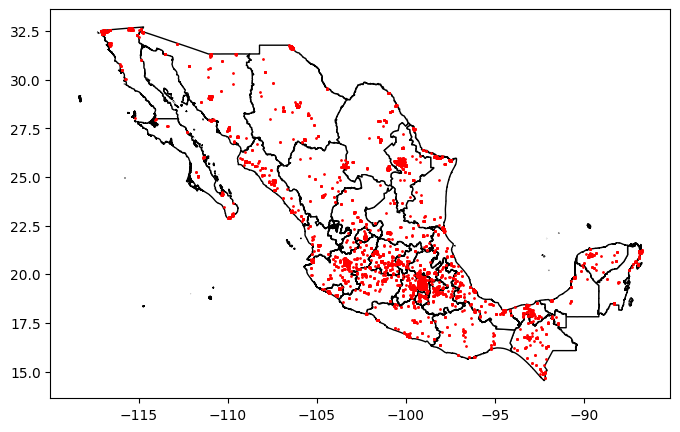

In [34]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_supermarkets_mex.plot(ax=ax, color='red', markersize=1)


In [36]:
# see clase_actividad_id
gdf_supermarkets_mex['CLASE_ACTIVIDAD_ID'].value_counts()

CLASE_ACTIVIDAD_ID
462111    7190
462112      87
461110      64
461212      27
431110      11
461121       9
435319       6
467112       4
461160       4
465915       4
461130       3
461150       2
561330       2
311612       2
431121       1
466111       1
813120       1
541610       1
468211       1
467111       1
531311       1
434211       1
722513       1
461190       1
465919       1
522110       1
465914       1
Name: count, dtype: int64

we want:
- 462111: super comercio al por menor supermercados
- 462112: minisupers idem


In [41]:
# razon social
gdf_supermarkets_mex['Razon_social'].value_counts().head(30)

Razon_social
NUEVA WAL MART DE MEXICO S DE RL DE CV        2915
TIENDAS SORIANA SA DE CV                       823
WALDOS DOLAR MART DE MEXICO S DE RL DE CV      579
                                               563
TIENDAS CHEDRAUI SA DE CV                      327
CASA LEY SAPI DE CV                            254
QAR SUPERMERCADOS SAPI DE CV                   114
CENTRAL DETALLISTA SA DE CV                    107
CORPORACION SANCHEZ SA DE CV                    92
COMERCIAL CITY FRESKO S DE RL DE CV             91
OPERADORA FUTURAMA SA DE CV                     88
SUPERMERCADOS INTERNACIONALES HEB SA DE CV      77
SUPERISSSTE                                     63
INSTITUTO MEXICANO DEL SEGURO SOCIAL            55
SUPER SAN FRANCISCO DE ASIS SA DE CV            53
COMERCIALIZADORA GRUPO SCORPION SA DE CV        49
OPERADORA DE CIUDAD JUAREZ SA DE CV             44
TIENDA DE DESCUENTO ARTELI SA DE CV             44
OPERADORA DE REYNOSA SA DE CV                   42
COSTCO DE MEXICO S

important supermarkets:

- NUEVA WAL MART DE MEXICO S DE RL DE CV
- TIENDAS SORIANA SA DE CV                       
- TIENDAS CHEDRAUI SA DE CV                      
- CASA LEY SAPI DE CV                            
- QAR SUPERMERCADOS SAPI DE CV                   
- CORPORACION SANCHEZ SA DE CV                   
- COMERCIAL CITY FRESKO S DE RL DE CV            
- OPERADORA FUTURAMA SA DE CV                    
- SUPERMERCADOS INTERNACIONALES HEB SA DE CV     
- SUPERISSSTE                                   
- INSTITUTO MEXICANO DEL SEGURO SOCIAL          
- SUPER SAN FRANCISCO DE ASIS SA DE CV          
- COSTCO DE MEXICO SA DE CV                     

In [42]:
# count estrato
gdf_supermarkets_mex['Estrato'].value_counts()

Estrato
11 a 30 personas      1953
101 a 250 personas    1876
51 a 100 personas     1513
0 a 5 personas         987
31 a 50 personas       557
6 a 10 personas        431
251 y más personas     111
Name: count, dtype: int64

In [71]:
pd.to_datetime(gdf_supermarkets_mex['Fecha_Alta'], format='%Y-%m', errors='coerce').describe()

count                             7421
mean     2015-03-17 09:06:25.662309888
min                2010-07-01 00:00:00
25%                2010-07-01 00:00:00
50%                2014-12-01 00:00:00
75%                2019-11-01 00:00:00
max                2024-05-01 00:00:00
Name: Fecha_Alta, dtype: object

<Axes: xlabel='Fecha_Alta'>

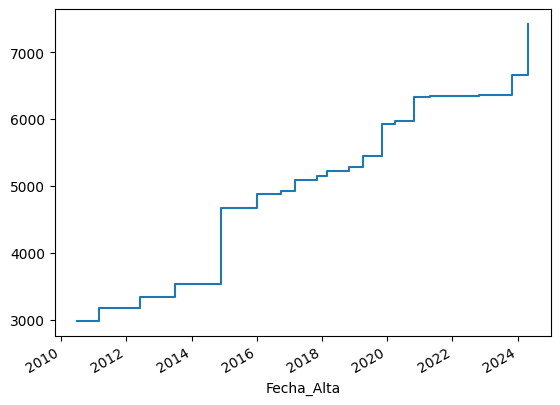

In [146]:
# time series of counts of Fecha_Alta: the date format is 'YYYY-MM'
gdf_supermarkets_mex['Fecha_Alta'] = pd.to_datetime(gdf_supermarkets_mex['Fecha_Alta'], format='%Y-%m', errors='coerce')

# plot ts
(
    gdf_supermarkets_mex
    .groupby('Fecha_Alta')
    # cum sum
    .size()
    .cumsum()
    .plot(drawstyle='steps-post')
)

<Axes: xlabel='id_sentidad_f'>

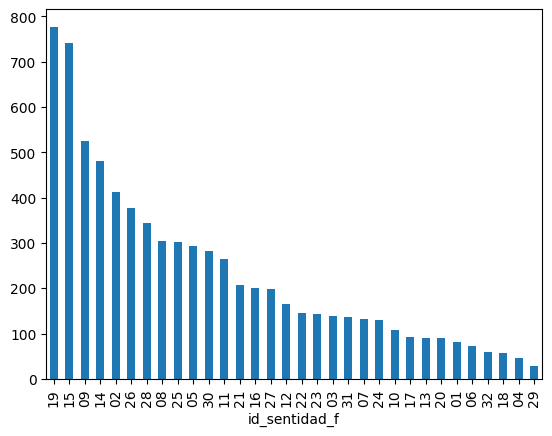

In [78]:
# see distributio by id_entidad_f
gdf_supermarkets_mex['id_sentidad_f'] = gdf_supermarkets_mex['AreaGeo'].str[:2]
gdf_supermarkets_mex['id_sentidad_f'].value_counts().plot(kind='bar')

### Filter

In [119]:
# params
clase_actividad_list = [
    462111
]

# important supermarkets
important_supermarkets = [
    'NUEVA WAL MART DE MEXICO S DE RL DE CV',
    'TIENDAS SORIANA SA DE CV',
    'TIENDAS CHEDRAUI SA DE CV',
    'CASA LEY SAPI DE CV',
    'QAR SUPERMERCADOS SAPI DE CV',
    'CORPORACION SANCHEZ SA DE CV',
    'COMERCIAL CITY FRESKO S DE RL DE CV',
    'OPERADORA FUTURAMA SA DE CV',
    'SUPERMERCADOS INTERNACIONALES HEB SA DE CV',
    'SUPERISSSTE',
    'INSTITUTO MEXICANO DEL SEGURO SOCIAL',
    'SUPER SAN FRANCISCO DE ASIS SA DE CV',
    'COSTCO DE MEXICO SA DE CV'
]

# estrato levels
estrato_categories = [
    '0 a 5 personas',
    '6 a 10 personas',
    '11 a 30 personas',
    '31 a 50 personas',
    '51 a 100 personas',
    '101 a 250 personas',
    '251 y más personas'
]

# important columns
vars_to_stay = [
    'CLEE', 'Nombre', 'Razon_social', 'Clase_actividad', 'estrato_category',
    'CLASE_ACTIVIDAD_ID', 'AreaGeo', 'id_entidad_f', 'Fecha_Alta', 'geometry'
]

In [120]:
# modify dataframe
gdf_supermarkets_mex2 = (
    gdf_supermarkets_mex
    .assign(
        estrato_category=lambda x: pd.Categorical(
            x['Estrato'],
            categories=estrato_categories,
            ordered=True
        ),
        Razon_social=lambda x: 
            x['Razon_social'].str.strip().str.upper(),
        id_entidad_f=lambda x: x['AreaGeo'].str[:2],
        Fecha_Alta=lambda x: pd.to_datetime(
            x['Fecha_Alta'], format='%Y-%m', errors='coerce'
            )
    )
    .astype({
        'CLASE_ACTIVIDAD_ID': 'int64'
    })
    # filters
    .query("CLASE_ACTIVIDAD_ID.isin(@clase_actividad_list)")
    .query("Razon_social.isin(@important_supermarkets)")
    .query("estrato_category >= '11 a 30 personas'")
    .reset_index(drop=True)
    .loc[:, vars_to_stay]
)
gdf_supermarkets_mex2

,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry
0,11017462111000147000003517S6,010 LA COMER IRAPUATO,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,110170001,11,2010-07-01,POINT (-101.35774 20.69011)
1,15104462111000326000003517S9,012 LACOMER EL DORADO,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,251 y más personas,462111,151040001,15,2010-07-01,POINT (-99.21389 19.54638)
2,15037462111000066000003517S6,014 LA COMER LOMAS ANAHUAC,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,251 y más personas,462111,150370071,15,2010-07-01,POINT (-99.27475 19.39943)
3,09012462111000086000003517S9,017 LA COMER TLALPAN,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,090120001,09,2010-07-01,POINT (-99.17940 19.28945)
4,16102462111000076000003517S4,034 LA COMER URUAPAN,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,161020001,16,2010-07-01,POINT (-102.05535 19.40129)
...,...,...,...,...,...,...,...,...,...,...
4642,22014462111001035000002514S6,WALMART EXPRESS PABELLON CAMPESTRE 4581,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,51 a 100 personas,462111,220060044,22,2024-05-01,POINT (-100.41220 20.56049)
4643,11020462111000746000002514S9,WALMART LA ANTORCHA 1621,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,110200001,11,2016-01-01,POINT (-101.73356 21.17324)
4644,20390462111000016000002514S3,WALMART MACRO PLAZA 1804,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,462111,203900001,20,2016-01-01,POINT (-96.69440 17.06862)
4645,13050462111000015000002514S4,WALMART VALLE DEL MEZQUITAL 3050,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,51 a 100 personas,462111,130500001,13,2010-07-01,POINT (-99.19269 20.24038)


### Mini EDA of Filtered Info

<Axes: >

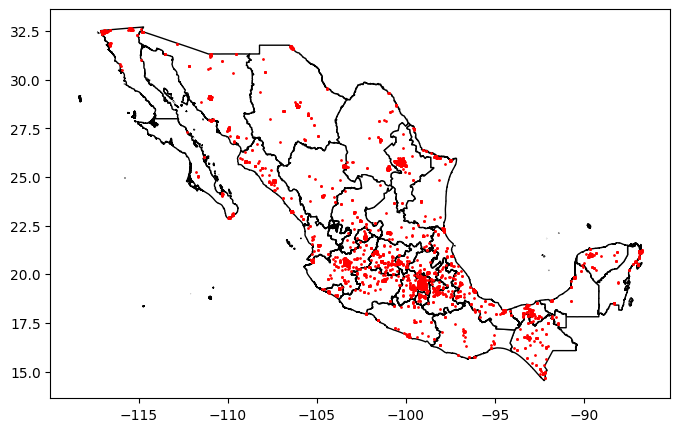

In [121]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_supermarkets_mex2.plot(ax=ax, color='red', markersize=1)


In [122]:
# see clase_actividad_id
gdf_supermarkets_mex2['CLASE_ACTIVIDAD_ID'].value_counts()

CLASE_ACTIVIDAD_ID
462111    4647
Name: count, dtype: int64

In [127]:
# razon social
gdf_supermarkets_mex2['Razon_social'].value_counts(normalize=True)

Razon_social
NUEVA WAL MART DE MEXICO S DE RL DE CV        0.574779
TIENDAS SORIANA SA DE CV                      0.174091
TIENDAS CHEDRAUI SA DE CV                     0.069077
CASA LEY SAPI DE CV                           0.052077
QAR SUPERMERCADOS SAPI DE CV                  0.021519
COMERCIAL CITY FRESKO S DE RL DE CV           0.018937
OPERADORA FUTURAMA SA DE CV                   0.018291
SUPERMERCADOS INTERNACIONALES HEB SA DE CV    0.014848
CORPORACION SANCHEZ SA DE CV                  0.014848
SUPERISSSTE                                   0.012266
SUPER SAN FRANCISCO DE ASIS SA DE CV          0.010975
INSTITUTO MEXICANO DEL SEGURO SOCIAL          0.009899
COSTCO DE MEXICO SA DE CV                     0.008393
Name: proportion, dtype: float64

<Axes: xlabel='estrato_category'>

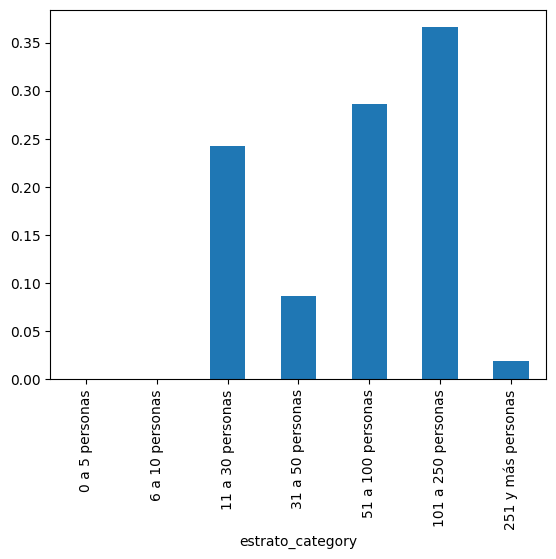

In [133]:
# count estrato
gdf_supermarkets_mex2['estrato_category'].value_counts(normalize=True).sort_index().plot(kind='bar')

In [137]:
# describe
gdf_supermarkets_mex2['Fecha_Alta'].describe()

count                             4643
mean     2014-08-28 03:18:10.932586752
min                2010-07-01 00:00:00
25%                2010-07-01 00:00:00
50%                2013-07-01 00:00:00
75%                2017-03-01 00:00:00
max                2024-05-01 00:00:00
Name: Fecha_Alta, dtype: object

<Axes: xlabel='Fecha_Alta'>

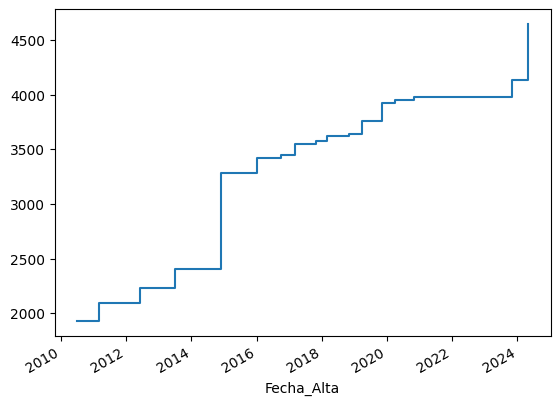

In [145]:
# plot ts
(
    gdf_supermarkets_mex2
    .groupby('Fecha_Alta')
    # cum sum
    .size()
    .cumsum()
    .plot(drawstyle='steps-post')
)

<Axes: xlabel='id_entidad_f'>

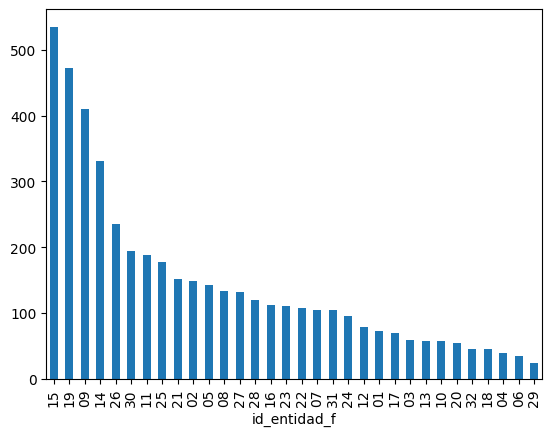

In [144]:
# see distributio by id_entidad_f
gdf_supermarkets_mex2['id_entidad_f'].value_counts().plot(kind='bar')

In [102]:
# razon social
gdf_supermarkets_mex2['Razon_social'].value_counts().head(30)

Razon_social
NUEVA WAL MART DE MEXICO S DE RL DE CV        2915
TIENDAS SORIANA SA DE CV                       823
TIENDAS CHEDRAUI SA DE CV                      327
CASA LEY SAPI DE CV                            254
QAR SUPERMERCADOS SAPI DE CV                   112
CORPORACION SANCHEZ SA DE CV                    92
COMERCIAL CITY FRESKO S DE RL DE CV             91
OPERADORA FUTURAMA SA DE CV                     88
SUPERMERCADOS INTERNACIONALES HEB SA DE CV      73
SUPERISSSTE                                     63
INSTITUTO MEXICANO DEL SEGURO SOCIAL            55
SUPER SAN FRANCISCO DE ASIS SA DE CV            53
COSTCO DE MEXICO SA DE CV                       39
Name: count, dtype: int64

In [113]:
gdf_supermarkets_mex2

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,Colonia,CP,Ubicacion,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,tipo_corredor_industrial,nom_corredor_industrial,numero_local,AGEB,Manzana,CLASE_ACTIVIDAD_ID,EDIFICIO_PISO,SECTOR_ACTIVIDAD_ID,SUBSECTOR_ACTIVIDAD_ID,RAMA_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,EDIFICIO,Tipo_Asentamiento,Fecha_Alta,AreaGeo,geometry,id_sentidad_f,estrato_category
0,11017462111000147000003517S6,6330332,010 LA COMER IRAPUATO,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,CALLE,CALLE DEL BOSQUE,1,,LAS REYNAS,36660,"IRAPUATO, Irapuato, GUANAJUATO",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-101.357738,20.690109,,,,0097,049,462111,,46,462,4621,46211,,FRACCIONAMIENTO,2010-07-01,110170001,POINT (-101.35774 20.69011),11,101 a 250 personas
1,15104462111000326000003517S9,6354328,012 LACOMER EL DORADO,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,251 y más personas,CALLE,ATENAS,6,,VALLE DORADO,54020,"TLALNEPANTLA, Tlalnepantla de Baz, MÉXICO ...",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-99.213886,19.546376,,,,0232,019,462111,,46,462,4621,46211,,FRACCIONAMIENTO,2010-07-01,151040001,POINT (-99.21389 19.54638),15,251 y más personas
2,15037462111000066000003517S6,6353986,014 LA COMER LOMAS ANAHUAC,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,251 y más personas,AVENIDA,DE LAS PALMAS,1,2,SAN FERNANDO HUIXQUILUCAN,52784,"NAUCALPAN DE JUÁREZ, Huixquilucan, MÉXICO ...",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-99.274747,19.399433,,,,0115,015,462111,,46,462,4621,46211,,COLONIA,2010-07-01,150370071,POINT (-99.27475 19.39943),15,251 y más personas
3,09012462111000086000003517S9,6314534,017 LA COMER TLALPAN,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,CALLE,AYUNTAMIENTO,1,,LA FAMA,14110,"TLALPAN, Tlalpan, CIUDAD DE MÉXICO",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-99.179404,19.289452,,,,0680,003,462111,,46,462,4621,46211,,COLONIA,2010-07-01,090120001,POINT (-99.17940 19.28945),09,101 a 250 personas
4,16102462111000076000003517S4,6358942,034 LA COMER URUAPAN,COMERCIAL CITY FRESKO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,CALLE,PASEO GENERAL LÁZARO CÁRDENAS,1800,,LOS ANGELES,60160,"URUAPAN, Uruapan, MICHOACÁN DE OCAMPO",,YPALACIOS@LACOMER.COM.MX,WWW.LACOMER.COM.MX,Fijo,-102.055348,19.401290,,,,0374,004,462111,,46,462,4621,46211,,COLONIA,2010-07-01,161020001,POINT (-102.05535 19.40129),16,101 a 250 personas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,22014462111001035000002514S6,9393317,WALMART EXPRESS PABELLON CAMPESTRE 4581,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,51 a 100 personas,CALLE,CANDILES,,,SN JOSE DE LOS OLVERA,76190,"SAN JOSÉ DE LOS OLVERA, Corregidora, QUERÉTARO...",,,WWW.WALMART.COM.MX,Fijo,-100.412197,20.560489,,,,0180,002,462111,,46,462,4621,46211,,COLONIA,2024-05-01,220060044,POINT (-100.41220 20.56049),22,51 a 100 personas
4644,11020462111000746000002514S9,6701049,WALMART LA ANTORCHA 1621,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,BOULEVARD,LIBRAMIENTO JOSÉ MARÍA MORELOS PONIENTE,,,CANADA DEL REFUGIO,37665,"LEÓN DE LOS ALDAMA, León, GUANAJUATO",,,WWW.WALMART.COM.MX,Fijo,-101.733564,21.173242,,,,730A,016,462111,,46,462,4621,46211,,COLONIA,2016-01-01,110200001,POINT (-101.73356 21.17324),11,101 a 250 personas
4645,20390462111000016000002514S3,6727564,WALMART MACRO PLAZA 1804,NUEVA WAL MART DE MEXICO S DE RL DE CV,Comercio al por menor en supermercados,101 a 250 personas,CARRETERA,INTERNACIONAL,42,,NUEVA SANTA LUCIA,71228,"SANTA LUCÍA DEL CAMINO, Santa Lucía del Camino...",,,WWW.WALMART.COM.MX,Fijo,-96.694397,17.068615,,,,011A,021,462111,,

## Hospitals Analysis

- 62211: hospitales generales

### Fetch All Info

In [148]:
# search for supermarkets
gdf_hospitals_mex = denue_api.BuscarAreaAct(
    nombre='hospitales',
    clave_area='00',
    registro_inicial=0,
    registro_final=100_000,
    estrato='0'
)

# see shape
gdf_hospitals_mex.shape

(11015, 35)

In [152]:
# see a sample
gdf_hospitals_mex.sample(5)

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,Colonia,CP,Ubicacion,Telefono,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,tipo_corredor_industrial,nom_corredor_industrial,numero_local,AGEB,Manzana,CLASE_ACTIVIDAD_ID,EDIFICIO_PISO,SECTOR_ACTIVIDAD_ID,SUBSECTOR_ACTIVIDAD_ID,RAMA_ACTIVIDAD_ID,SUBRAMA_ACTIVIDAD_ID,EDIFICIO,Tipo_Asentamiento,Fecha_Alta,AreaGeo,geometry
10841,13061622112000011000000000U5,1613796,UNIDAD MEDICO RURAL NO 135 DE IMSS,GOBIERNO,Hospitales generales del sector público,0 a 5 personas,AVENIDA,GENERAL FELIPE ANGELES,,,PLAZA VIEJA,43976,"TEPEAPULCO, Tepeapulco, HIDALGO",,,,Fijo,-98.548008,19.784467,,,,0323,011,622112,,62,622,6221,62211,,COLONIA,2010-07,130610001,POINT (-98.54801 19.78447)
8196,06002462112000501002001970S1,6303910,KIOSKO 1929 HOSPITAL REGIONAL,SUPER KIOSKO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,BOULEVARD,CAMINO REAL DE COLIMA,1106,,EL DIEZMO,28010,"COLIMA, Colima, COLIMA",,DMANCILLA@MIKIOSKO.MX,WWW.MIKIOSKO.MX,Fijo,-103.689032,19.258889,,,,1388,001,462112,,46,462,4621,46211,,COLONIA,2010-07,060020001,POINT (-103.68903 19.25889)
9782,05018811420000401000000000U6,8692663,TAPICERIA HOSPITAL DE MUEBLES,,Reparación de tapicería de muebles para el hogar,0 a 5 personas,AVENIDA,FERROCARRIL,508,,DEPORTIVO,25760,"MONCLOVA, Monclova, COAHUILA DE ZARAGOZA",8666314566,,,Fijo,-101.437148,26.885034,,,,1148,030,811420,,81,811,8114,81142,,COLONIA,2019-11,050180001,POINT (-101.43715 26.88503)
2601,30045622111000022000000000S6,7366261,CRUZ ROJA MEXICANA,CRUZ ROJA MEXICANA SA DE CV,Hospitales generales del sector privado,6 a 10 personas,BOULEVARD,MIGUEL ALEMAN,,,MANLIO FABIO ALTAMIRANO,95390,"COSAMALOAPAN, Cosamaloapan de Carpio, VERACRUZ...",,,,Fijo,-95.802318,18.362153,,,,0465,029,622111,,62,622,6221,62211,,COLONIA,2019-11,300450001,POINT (-95.80232 18.36215)
6493,23005621113002601000000000U5,8727178,HOSPITAL QUIRURGICA DEL SUR,CONSULTORIO 201,Consultorios de medicina especializada del sec...,0 a 5 personas,AVENIDA,LOPEZ PORTILLO,,221,SUPERMANZANA 59,77515,"CANCÚN, Benito Juárez, QUINTANA ROO",,MARCOSSEGUIA@HOTMAI.COM,,Fijo,-86.857156,21.158951,,,,0328,019,621113,,62,621,6211,62111,,SUPERMANZANA,2019-11,230050001,POINT (-86.85716 21.15895)


### Filter

In [153]:
# params
clase_subrama_actividad_list = [
    62211
]

# estrato levels
estrato_categories = [
    '0 a 5 personas',
    '6 a 10 personas',
    '11 a 30 personas',
    '31 a 50 personas',
    '51 a 100 personas',
    '101 a 250 personas',
    '251 y más personas'
]

# important columns
vars_to_stay = [
    'CLEE', 'Nombre', 'Razon_social', 'Clase_actividad', 'estrato_category',
    'CLASE_ACTIVIDAD_ID', 'AreaGeo', 'id_entidad_f', 'Fecha_Alta', 'geometry'
]

In [180]:
# modify dataframe
gdf_hospitals_mex2 = (
    gdf_hospitals_mex
    .assign(
        estrato_category=lambda x: pd.Categorical(
            x['Estrato'],
            categories=estrato_categories,
            ordered=True
        ),
        Razon_social=lambda x: 
            x['Razon_social'].str.strip().str.upper(),
        id_entidad_f=lambda x: x['AreaGeo'].str[:2],
        Fecha_Alta=lambda x: pd.to_datetime(
            x['Fecha_Alta'], format='%Y-%m', errors='coerce'
            )
    )
    .astype({
        'CLASE_ACTIVIDAD_ID': 'int64',
        'SUBRAMA_ACTIVIDAD_ID': 'int64'

    })
    # filters
    .query("SUBRAMA_ACTIVIDAD_ID.isin(@clase_subrama_actividad_list)")
    .query("estrato_category >= '251 y más personas'")
    # .reset_index(drop=True)
    .loc[:, vars_to_stay]
)

# shape
gdf_hospitals_mex2.shape

(672, 10)

### Mini EDA

In [181]:
# clase actividad id
gdf_hospitals_mex2['CLASE_ACTIVIDAD_ID'].value_counts()

CLASE_ACTIVIDAD_ID
622112    559
622111    113
Name: count, dtype: int64

In [182]:
# hospitals with no razon social
gdf_hospitals_mex2.query("Razon_social == ''")

,CLEE,Nombre,Razon_social,Clase_actividad,estrato_category,CLASE_ACTIVIDAD_ID,AreaGeo,id_entidad_f,Fecha_Alta,geometry
406,11037622112000056001000000U2,CAISES SILAO HOSPITAL,,Hospitales generales del sector público,251 y más personas,622112,110370001,11,2010-07-01,POINT (-101.42573 20.94790)
3304,24028622112000217000000000U4,HOSPITAL,,Hospitales generales del sector público,251 y más personas,622112,240280001,24,2010-07-01,POINT (-100.98740 22.14818)
3685,28041622112000077000000000U1,HOSPITAL CIVIL DE CIUDAD VICTORIA,,Hospitales generales del sector público,251 y más personas,622112,280410001,28,2010-07-01,POINT (-99.15731 23.72807)
5564,26043622112000046001000000U4,HOSPITAL GENERAL,,Hospitales generales del sector público,251 y más personas,622112,260430001,26,2010-07-01,POINT (-110.94390 31.30955)
5573,02002622112000387000000000U6,HOSPITAL GENERAL 5 DE DICIEMBRE,,Hospitales generales del sector público,251 y más personas,622112,020020001,02,2010-07-01,POINT (-115.47481 32.64539)
5724,29033622112000037000000000U1,HOSPITAL GENERAL DE TLAXCALA,,Hospitales generales del sector público,251 y más personas,622112,290330001,29,2010-07-01,POINT (-98.24364 19.31860)
5737,32010622112000057000000000U2,HOSPITAL GENERAL DE ZONA 2 IMSS,,Hospitales generales del sector público,251 y más personas,622112,320100001,32,2010-07-01,POINT (-102.87106 23.16733)
5740,10007622112000051000000000U7,HOSPITAL GENERAL DE ZONA 46,,Hospitales generales del sector público,251 y más personas,622112,100070001,10,2010-07-01,POINT (-103.50613 25.55777)
5741,09007622112000197000000000U1,HOSPITAL GENERAL DE ZONA 47. VICENTE GUERRERO,,Hospitales generales del sector público,251 y más personas,622112,090070001,09,2010-07-01,POINT (-99.05387 19.35767)
5800,15013621116000017010000000U3,HOSPITAL GENERAL DOCTOR GONZALEZ HERREJON CHRY...,,Hospitales generales del sector público,251 y más personas,622112,150130001,15,2014-12-01,POINT (-99.23738 19.54683)


In [183]:
# razon social
gdf_hospitals_mex2['Razon_social'].value_counts(normalize=True).head(20)

Razon_social
INSTITUTO MEXICANO DEL SEGURO SOCIAL                                          0.159226
INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO    0.043155
                                                                              0.037202
OPERADORA DE HOSPITALES ANGELES SA DE CV                                      0.035714
IMSS                                                                          0.029762
GOBIERNO FEDERAL                                                              0.023810
GOBIERNO                                                                      0.020833
PETROLEOS MEXICANOS                                                           0.019345
SECRETARIA DE SALUD                                                           0.017857
SERVICIOS DE SALUD DE VERACRUZ                                                0.011905
EL GOBIERNO                                                                   0.008929
SECRETARÍA DE SALUD           

In [184]:
# count estrato
gdf_hospitals_mex2['estrato_category'].value_counts(normalize=True).sort_index()

estrato_category
0 a 5 personas        0.0
6 a 10 personas       0.0
11 a 30 personas      0.0
31 a 50 personas      0.0
51 a 100 personas     0.0
101 a 250 personas    0.0
251 y más personas    1.0
Name: proportion, dtype: float64

In [185]:
# explore
(
    gdf_hospitals_mex2
    .loc[:, ['Razon_social', 'geometry', 'estrato_category']]
    .explore(tiles='cartodb positron', tooltip=['Razon_social', 'estrato_category'])
    )

<Axes: >

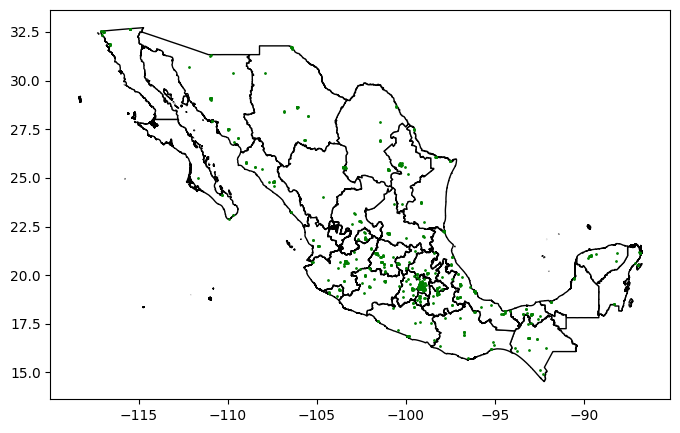

In [186]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_hospitals_mex2.plot(ax=ax, color='green', markersize=1)

## Schools Analysis

---
# Sandbox

In [147]:
# columns
gdf_supermarkets.columns

Index(['CLEE', 'Id', 'Nombre', 'Razon_social', 'Clase_actividad', 'Estrato',
       'Tipo_vialidad', 'Calle', 'Num_Exterior', 'Num_Interior', 'Colonia',
       'CP', 'Ubicacion', 'Telefono', 'Correo_e', 'Sitio_internet', 'Tipo',
       'Longitud', 'Latitud', 'CentroComercial', 'TipoCentroComercial',
       'NumLocal', 'geometry'],
      dtype='object')